<a href="https://colab.research.google.com/github/ggarcia-de-souza/otimizacao_modelos/blob/main/Otimiza%C3%A7%C3%A3o_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()


,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [10]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [11]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [12]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [13]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [14]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [15]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold


SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [16]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [17]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


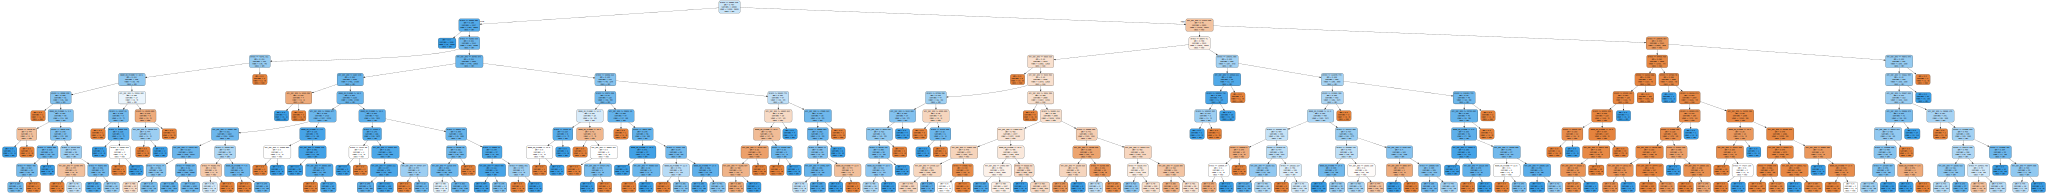

In [18]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [19]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, train_score, test_score]
  return tabela


for i in range (1, 33):
      roda_arvore_de_decisao(i)

#Esse algoritmo está gabaritando o treino. Decorando basicamente tudo. Mas, para um teste ele está perdendo seu poder de previsão.      

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

In [20]:
resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


<Axes: xlabel='max_depth', ylabel='train'>

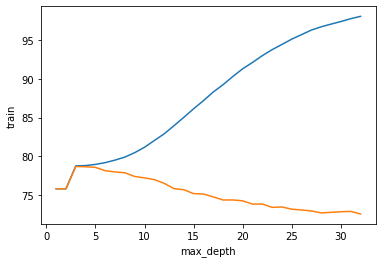

In [21]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)

#Caso de Overfit

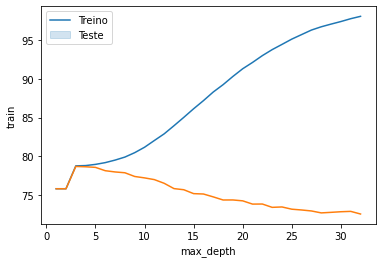

In [22]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [23]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiper parâmetros em 2 dimensões

In [24]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [25]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


# Tentando encontrar uma correlação de entre esses paramêtros

<Axes: >

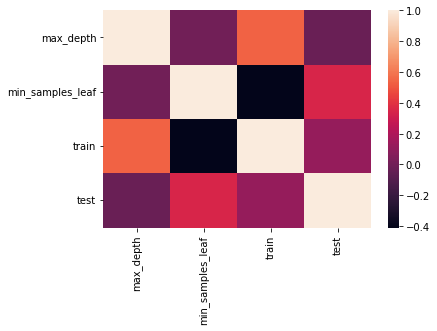

In [26]:
corr = resultados.corr()
sns.heatmap(corr)

array([[<Axes: xlabel='max_depth', ylabel='max_depth'>,
        <Axes: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <Axes: xlabel='train', ylabel='max_depth'>,
        <Axes: xlabel='test', ylabel='max_depth'>],
       [<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <Axes: xlabel='train', ylabel='min_samples_leaf'>,
        <Axes: xlabel='test', ylabel='min_samples_leaf'>],
       [<Axes: xlabel='max_depth', ylabel='train'>,
        <Axes: xlabel='min_samples_leaf', ylabel='train'>,
        <Axes: xlabel='train', ylabel='train'>,
        <Axes: xlabel='test', ylabel='train'>],
       [<Axes: xlabel='max_depth', ylabel='test'>,
        <Axes: xlabel='min_samples_leaf', ylabel='test'>,
        <Axes: xlabel='train', ylabel='test'>,
        <Axes: xlabel='test', ylabel='test'>]], dtype=object)

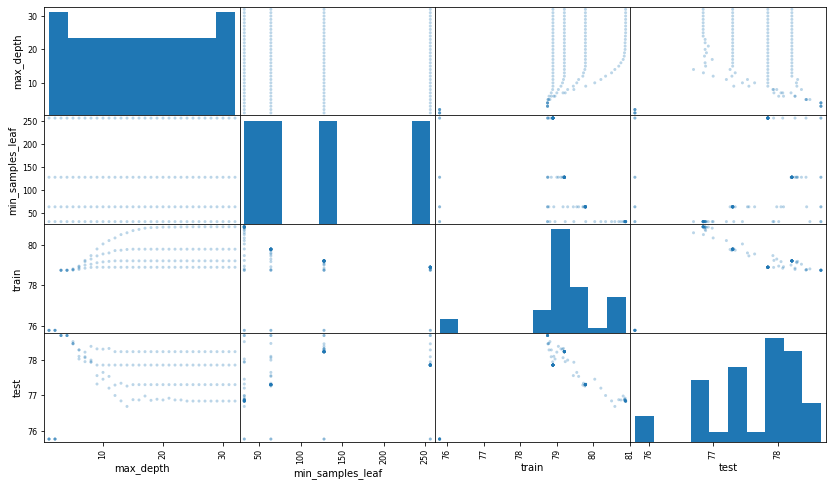

In [27]:
from pandas.plotting import scatter_matrix

# Visualizando a matriz através do pandas
scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

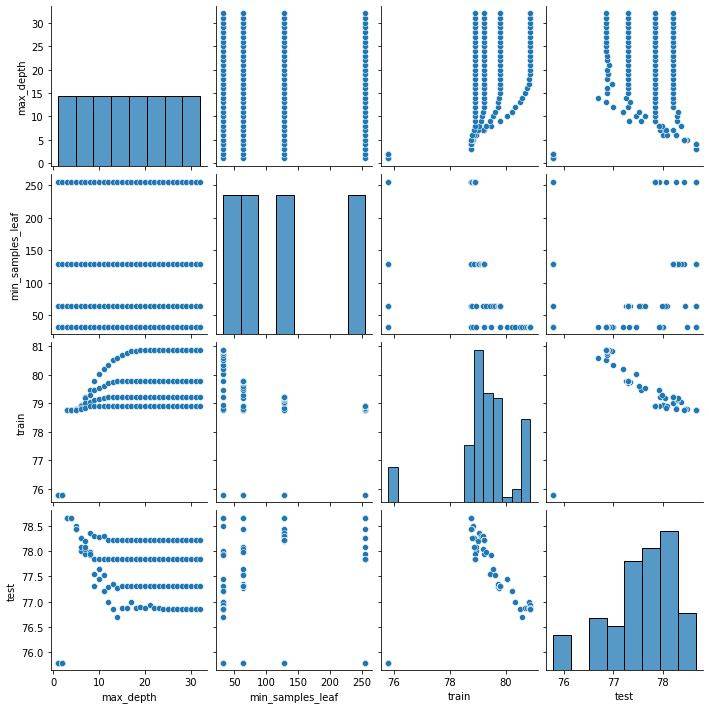

In [28]:
sns.pairplot(resultados)

# min_samples_leaf está correlacionado com o teste

# max_depth está correlacionado com o train

<ipython-input-29-db34b24cd1a1>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

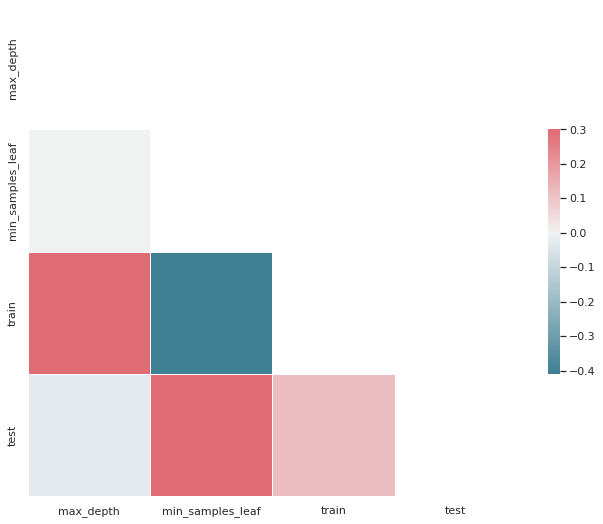

In [29]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [31]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


<ipython-input-32-6d96d956169d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

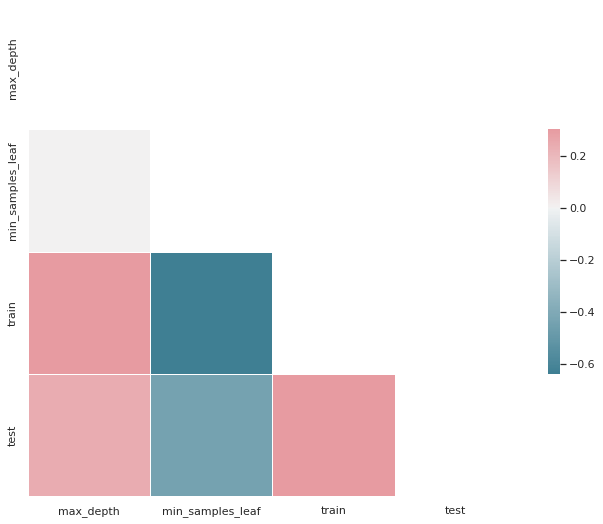

In [32]:
corr = resultados.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando hiper parâmetros em 3 dimensões

In [33]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


<ipython-input-34-6d96d956169d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

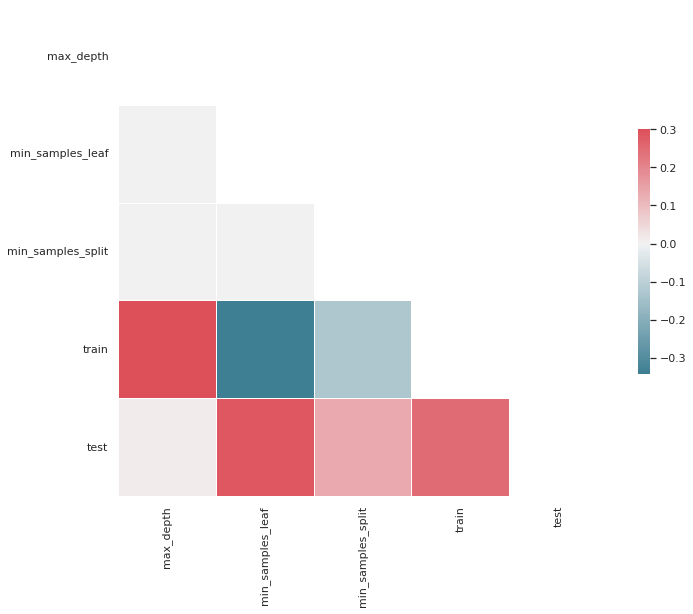

In [34]:
corr = resultados.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Fit_time = Tempo de treino
# Score_time = Tempo de teste

In [35]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.004613,0.001340
1,1,32,64,75.791169,75.784219,0.004910,0.001445
2,1,32,128,75.791169,75.784219,0.004614,0.001375
3,1,32,256,75.791169,75.784219,0.004649,0.001489
4,1,64,32,75.791169,75.784219,0.004749,0.001644


In [36]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.010360,0.001749
48,4,32,32,78.750993,78.672633,0.013866,0.002423
34,3,32,128,78.750993,78.672633,0.009094,0.001963
35,3,32,256,78.750993,78.672633,0.008840,0.001521
36,3,64,32,78.750993,78.672633,0.009261,0.001616


# Explorando espaço de hiper parâmetros com GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009304,0.001220,0.001585,0.000151,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.009079,0.000481,0.001620,0.000110,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008876,0.000161,0.001595,0.000123,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.008892,0.000071,0.001647,0.000139,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.009120,0.000537,0.001743,0.000380,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [38]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [39]:
from sklearn import set_config
set_config(print_changed_only=False)

melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=32,
                       min_samples_split=32, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')


In [40]:
from sklearn.metrics import accuracy_score 

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Usando validação cruzada com hiper parâmetros

In [46]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026255,0.006660,0.004903,0.003569,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.012512,0.005470,0.003756,0.003101,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010113,0.000790,0.002187,0.000376,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010143,0.000370,0.002284,0.000446,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.009641,0.000218,0.001967,0.000106,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=5), groups = dados.modelo, error_score='raise')
scores

array([0.79707219, 0.78762376, 0.78517777, 0.77828283, 0.78635015])

In [52]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [53]:
imprime_score(scores)

Accuracy médio 78.69
Intervalo [77.49, 79.90]


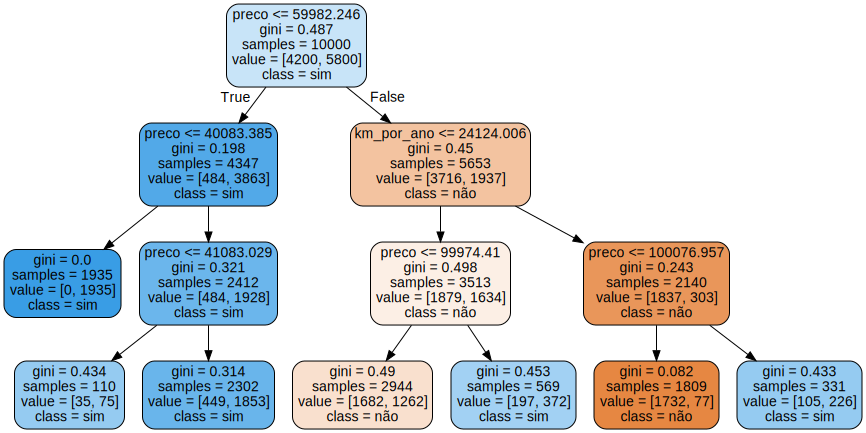

In [50]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph